# Multilayer thin film optimization

The language of transfer/scatter matrices is commonly used to calculate optical properties of thin-films [1]. Various analytical and numerical techniques have been developed to optimize multilayer thin films as a function of desired performance, and many commercial and open-source [2] software have resulted. PhotonTorch can also be used to apply automatic differentiation to this problem.

[1] https://www.photonics.intec.ugent.be/download/ocs129.pdf
[2] Larouche, S., & Martinu, L. (2008). OpenFilters: open-source software for the design, optimization, and synthesis of optical filters. Appl. Opt., 47(13), C219–C230. doi: 10.1364/AO.47.00C219

## Imports

In [1]:
%matplotlib inline
import torch
import numpy as np
import matplotlib.pyplot as plt
import photontorch as pt
from torch.nn import Parameter

## Fabry-Pérot cavity

Consider a stack composed of only two materials, one high index $n_A$ and one low-index $n_B$. Two types of transfer matrices characterize wave propagation in the system : interfaces described by Fresnel's equations, and propagation.

An interface has 4 scattering coefficients. Through reciprocity they can be constructed out of two independent ones :

In [2]:
class Interface(pt.Component):
    
    num_ports = 2 # this class variable always needs to be defined
    def __init__(self, ni=1., nj=1.):
        super(Interface, self).__init__()
        # Indices are fixed
        self.ni = float(ni) # Parameter(torch.tensor(ni))
        self.nj = float(nj) # Parameter(torch.tensor(nj))
        
    # Reflection at i-->j interface
    def r_ij(self, ni, nj):
        """
        Normal incidence amplitude reflection from Fresnel's equations
        ni : refractive index of the initial medium
        nf : refractive index of the final
        """
        return (self.ni - self.nj) / (self.ni + self.nj)

    # Transmission at i-->j interface
    def t_ij(self, ni, nj):
        """
        Normal incidence amplitude transmission from Fresnel's equations
        """
        return 2 * self.ni / (self.ni + self.nj)
        
    def set_S(self, S):        
        # real part scattering matrix (transmission):
        # (same transmission for all wavelengths)
        S[0, :, 0, 0] = self.r_ij(self.ni, self.nj)
        S[0, :, 0, 1] = self.t_ij(self.ni, self.nj)
        S[0, :, 1, 0] = (1 - (self.r_ij(self.ni, self.nj))**2 ) / self.t_ij(self.ni, self.nj)
        S[0, :, 1, 1] = -1*self.r_ij(self.ni, self.nj)

Propagation is similar to a waveguide :

In [3]:
class Propagation(pt.Component):
    
    num_ports = 2 # this class variable always needs to be defined
    def __init__(self, ni=1., di=1.):
        super(Propagation, self).__init__()
        # Handle inputs
        self.ni = float(ni) # Parameter(torch.tensor(ni))
        self.di = Parameter(torch.tensor(di, dtype=torch.float64))
        
    def set_S(self, S):
        wls = torch.tensor(self.env.wl, dtype=torch.float64, device=self.device)

        # neff depends on the wavelength:
        phase = (2 * np.pi * self.ni * self.di / wls)
        cos_phase = torch.cos(phase).to(torch.get_default_dtype())
        sin_phase = torch.sin(phase).to(torch.get_default_dtype())

        # calculate loss
        re = cos_phase
        ie = sin_phase

        # calculate real part and imag part
        S[0, :, 0, 1] = S[0, :, 1, 0] = re
        S[1, :, 0, 1] = S[1, :, 1, 0] = ie

The cavity can be defined. We add another detector to monitor reflection at the input side :

In [4]:
class FabryPerot(pt.Network):
    def __init__(self, nA=1., nB=2., d=1000.):
        super(FabryPerot, self).__init__() # always initialize first
        self.air_B = Interface(ni=nA, nj=nB)
        self.B = Propagation(ni=nB, di=d)
        self.B_air = Interface(ni=nB, nj=nA)
        self.source = pt.Source()
        self.transmission = pt.Detector()
        self.reflection = pt.Detector()
        
        self.link("source:0", "0:air_B:1", "0:B:1", "0:B_air:1", "0:transmission")
        self.link("reflection:0", "0:air_B:1", "0:B:1", "0:B_air:1", "0:transmission")

Performing the simulation in frequency space :

In [5]:
circuit = FabryPerot(nA=1., nB=2., d=1000.)
print(circuit.connections)

wls = np.linspace(380, 750, 1000)

# create simulation environment
freq_env = pt.Environment(
    wl=wls,
    freqdomain=True,
)

with freq_env:
    # perform simulation
    detected = circuit(source=1, power=False) # constant source with amplitude 1
    # Axis 3 [0,0,X,0,0] contains the detector index

['source:0:air_B:0', 'air_B:1:B:0', 'B:1:B_air:0', 'B_air:1:transmission:0', 'reflection:0:air_B:0', 'air_B:1:B:0', 'B:1:B_air:0', 'B_air:1:transmission:0']


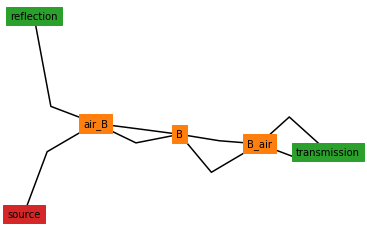

In [6]:
circuit.graph()

We can benchmark against another package (https://github.com/sbyrnes321/tmm) :

In [7]:
import sys
!$sys.executable -m pip install tmm
from tmm import coh_tmm

# tmm syntax (https://github.com/sbyrnes321/tmm)
d_list = [np.inf,1000,np.inf]
n_list = [1,2,1]
# initialize lists of y-values to plot
rnorm=[]
tnorm = []
for l in wls:
    rnorm.append(coh_tmm('s',n_list, d_list, 0, l)['r'])
    tnorm.append(coh_tmm('s',n_list, d_list, 0, l)['t'])

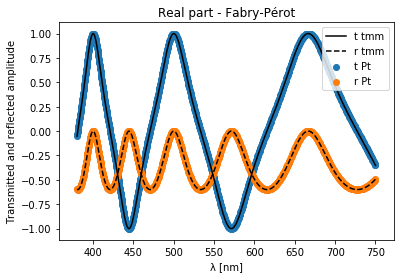

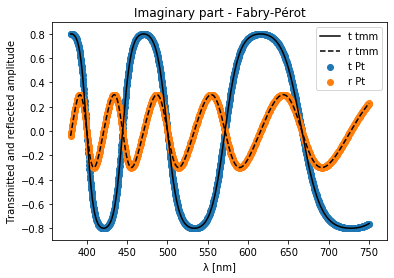

In [8]:
plt.scatter(wls, detected[0,0,:,0,0], label='t Pt')
plt.plot(wls, np.real(np.array(tnorm)), 'k', label='t tmm')
plt.scatter(wls, detected[0,0,:,1,0], label='r Pt')
plt.plot(wls, np.real(np.array(rnorm)), 'k--', label='r tmm')
plt.xlabel("λ [nm]")
plt.ylabel("Transmitted and reflected amplitude")
plt.legend(loc="upper right")
plt.title("Real part - Fabry-Pérot")
plt.show()

plt.scatter(wls, detected[1,0,:,0,0], label='t Pt')
plt.plot(wls, np.imag(np.array(tnorm)), 'k', label='t tmm')
plt.scatter(wls, detected[1,0,:,1,0], label='r Pt')
plt.plot(wls, np.imag(np.array(rnorm)), 'k--', label='r tmm')
plt.xlabel("λ [nm]")
plt.ylabel("Transmitted and reflected amplitude")
plt.legend(loc="upper right")
plt.title("Imaginary part - Fabry-Pérot")
plt.show()

### Optimization test

Let's see if we can extract gradients :

In [9]:
for p in circuit.parameters():
    print(p)

Parameter containing:
tensor(1000., dtype=torch.float64, requires_grad=True)


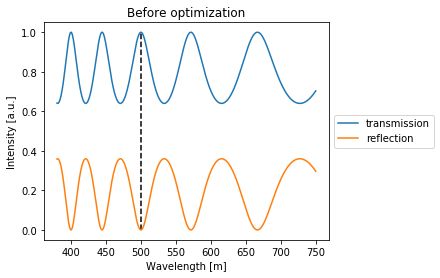

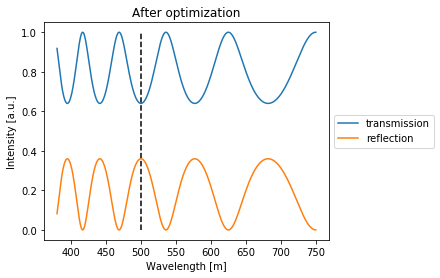

Parameter containing:
tensor(937.6025, dtype=torch.float64, requires_grad=True)


In [10]:
# define simualation environment
train_env = pt.Environment(
    wl=500, # we want minimal transmission at this wavelength
    freqdomain=True, # we will do frequency domain simulations
    grad=True, # gradient need to be tracked in order to use gradient descent.
)

# Plot initial
with freq_env:
    detected = circuit(source=1) # constant source with amplitude 1
    circuit.plot(detected);
    plt.vlines(500, 0, 1, 'k', linestyle='--')
    plt.title("Before optimization")

    plt.show()

# define target for the simulation, lets take 0 (ideally no transmission at resonance)
target = 0

# let's define an optimizer.
# The Adam optimizer is generally considered to be the best
# gradient descent optimizer out there:
optimizer = torch.optim.Adam(circuit.parameters(), lr=10)

# do the training
with train_env:
    for epoch in range(100):
        optimizer.zero_grad() # reset the optimizer and gradients
        detected = circuit(source=1, power=True) # simulate
        loss = ((detected-target)**2).mean() # calculate mse loss
        loss.backward() # calculate the gradients on the parameters
        optimizer.step() # update the parameters according to the gradients
        
# view result
with freq_env:
    detected = circuit(source=1) # constant source with amplitude 1
    circuit.plot(detected);
    plt.vlines(500, 0, 1, 'k', linestyle='--')
    plt.title("After optimization")

    plt.show()
    
# print parameters
for p in circuit.parameters():
    print(p)

## Notch filter

Let's consider something more complicated : a 2-material notch filter that reflects for a narrow range of wavelengths around $\lambda_0$, and nowhere else. An intuitive starting point is the stack [1,2]

$$ n_i | \left[ (2-p)ApB\right]^N | n_f $$

with $n_i$ and $n_f$ boundary indices, A and B the respective quarter wave plates at $\lambda_0$

$$ A \rightarrow d=\frac{1}{4}\frac{\lambda_0}{n_A} \text{ of } n_A$$
$$ B \rightarrow d=\frac{1}{4}\frac{\lambda_0}{n_B}  \text{ of } n_B $$

and $p$ is small. The analytical expressions of [2] with materials $n_A = 2.35$, $n_B = 1.45$, and target $\lambda_0 = 532$ nm require $p = 0.12$ and $N = 140$ for adequate performance. 

[1] https://www.optilayer.com/notch-filters

[2] T.V. Amotchkina, "Analytical estimations for the reference wavelength reflectance and width of high reflection zone of two-material periodic multilayers," Appl. Opt. 52, 4590-4595 (2013).

Let's see how a single such layer surrounded by air performs :

In [11]:
nA = 2.35
nB = 1.45
p = 0.12
wl0 = 532.
ni = 1.
nf = 1.

dA = (2 - p)*wl0/4/nA
dB = p*wl0/4/nB

print(dA)
print(dB)

106.39999999999999
11.006896551724138


We will define specific components with default values the (unchanging) indices of refraction

In [12]:
class NotchFilter(pt.Network):
    def __init__(self, 
                 N=30, 
                 nA=2.35, 
                 nB=1.45, 
                 dA=106.39999999999999, 
                 dB=11.006896551724138, 
                 ni=1., 
                 nf=1.
                ):
        super(NotchFilter, self).__init__() # always initialize parent first
        
        # handle variables
        self.N = int(N)
        self.nA = float(nA)
        self.nB = float(nB)
        self.dA = float(dA)
        self.dB = float(dB)
        self.ni = float(ni)
        self.nf = float(nf)
        
        # define source and detectors:
        self.source = pt.Source()
        self.transmission = pt.Detector()
        #self.reflection = pt.Detector()
        
        # Input
        self.iA = Interface(ni=self.ni, nj=self.nA)
        
        # Repeated layers
        for i in range(self.N):
            self.add_component(
                name=f"{i}_A",
                comp=Propagation(ni=self.nA, di=self.dA)
            )
            self.add_component(
                name=f"{i}_AB",
                comp=Interface(ni=self.nA, nj=self.nB)
            )
            self.add_component(
                name=f"{i}_B",
                comp=Propagation(ni=self.nB, di=self.dB)
            )
            self.add_component(
                name=f"{i}_BA",
                comp=Interface(ni=self.nB, nj=self.nA)
            )

        # Final layer
        self.add_component(
            name=f"{self.N}_A",
            comp=Propagation(ni=self.nA, di=self.dA)
        )
        self.add_component(
            name=f"{self.N}_AB",
            comp=Interface(ni=self.nA, nj=self.nB)
        )
        self.add_component(
            name=f"{self.N}_B",
            comp=Propagation(ni=self.nB, di=self.dB)
        )
        self.add_component(
            name="Bf",
            comp=Interface(ni=self.nB, nj=self.nf)
        )
        
        # lets now define the links
        link_T = ["source:0", "0:iA:1"]
        for i in range(self.N):
            link_T += [f"0:{i}_A:1", f"0:{i}_AB:1", f"0:{i}_B:1", f"0:{i}_BA:1"]
        link_T += [f"0:{N}_A:1", f"0:{N}_AB:1", f"0:{N}_B:1", 
                   f"0:Bf:1", "0:transmission"]
        
#         link_R = ["reflection:0", "0:iA:1"]
#         for i in range(self.N):
#             link_R += [f"0:{i}_A:1", f"0:{i}_AB:1", f"0:{i}_B:1", f"0:{i}_BA:1"]
#         link_R += [f"0:{N}_A:1", f"0:{N}_AB:1", f"0:{N}_B:1", 
#                    f"0:Bf:1", "0:transmission"]
        
                    
        self.link(*link_T)
        #self.link(*link_R)

In [13]:
N=20

circuit = NotchFilter(N=N)

# create simulation environment
freq_env = pt.Environment(
    wl=wls,
    freqdomain=True,
)

with freq_env:
    # perform simulation
    detected = circuit(source=1, power=True) # constant source with amplitude 1
    # Axis 3 [0,0,X,0,0] contains the detector index

In [14]:
d_list = []
n_list = []

d_list.append(np.inf)
n_list.append(1.)

for i in range(N+1): # From way N defined in stack circuit
    d_list.append(dA)
    n_list.append(nA)
    d_list.append(dB)
    n_list.append(nB)

d_list.append(np.inf)
n_list.append(1.)

#Rnorm=[]
Tnorm=[]
for l in wls:
    Tnorm.append(coh_tmm('s',n_list, d_list, 0, l)['T'])
    #Rnorm.append(coh_tmm('s',n_list, d_list, 0, l)['R'])

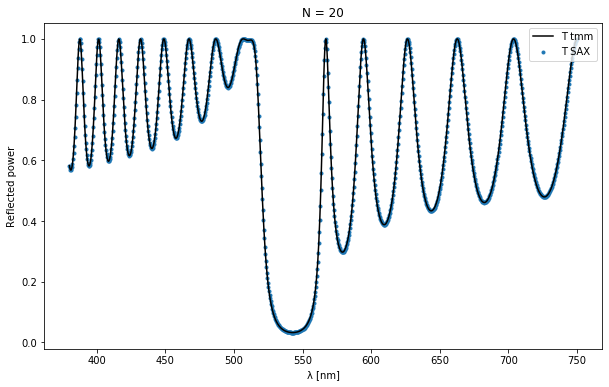

In [15]:
plt.figure(figsize=[10,6])
# plt.scatter(wls, detected[0,:,1,0], marker='.', label='R Pt')
# plt.plot(wls, Rnorm, 'k--', label='R tmm')
plt.scatter(wls, detected[0,:,0,0], marker='.', label='T SAX')
plt.plot(wls, Tnorm, 'k', label='T tmm')
plt.xlabel("λ [nm]")
plt.ylabel("Reflected power")
plt.legend(loc="upper right")
plt.title("N = {}".format(N))
plt.show()

Now we see notch behaviour. Let's optimize the ripples away :

In [36]:
target = np.ones(len(wls))
target[np.where(np.array(Tnorm) < 0.2)] = 0.

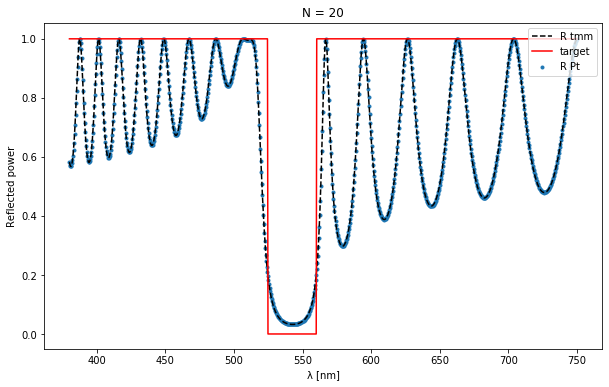

In [37]:
plt.figure(figsize=[10,6])
plt.scatter(wls, detected, marker='.', label='R Pt')
plt.plot(wls, Tnorm, 'k--', label='R tmm')
plt.plot(wls, target, 'r', label='target')
plt.xlabel("λ [nm]")
plt.ylabel("Reflected power")
plt.legend(loc="upper right")
plt.title("N = {}".format(N))
plt.show()

In [38]:
device = 'cpu' # 'cpu' or 'cuda'
stack = NotchFilter(N=N).to(device)

In [48]:
# define simualation environment
train_env = pt.Environment(
    wl=wls,
    freqdomain=True,
    grad=True,
)

# let's define an optimizer.
# The Adam optimizer is generally considered to be the best
# gradient descent optimizer out there:
optimizer = torch.optim.Adam(stack.parameters(), lr=1)

target_torch = torch.tensor(target)

  0%|          | 0/20 [00:00<?, ?it/s]

0


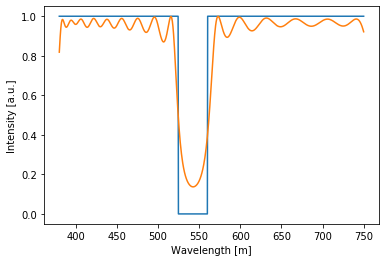

tensor(0.0123, dtype=torch.float64, grad_fn=<MseLossBackward>)
1


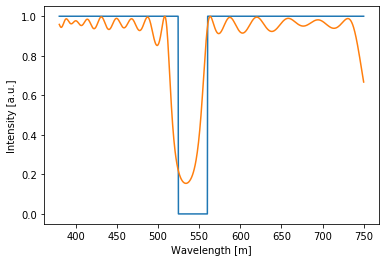

tensor(0.0306, dtype=torch.float64, grad_fn=<MseLossBackward>)
2


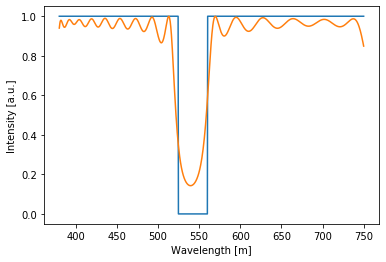

tensor(0.0134, dtype=torch.float64, grad_fn=<MseLossBackward>)
3


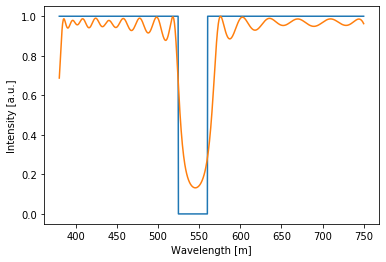

tensor(0.0162, dtype=torch.float64, grad_fn=<MseLossBackward>)
4


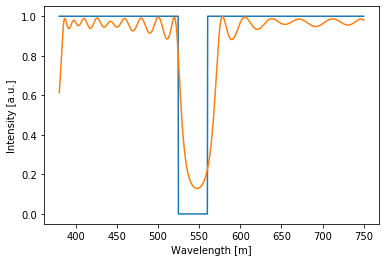

tensor(0.0220, dtype=torch.float64, grad_fn=<MseLossBackward>)
5


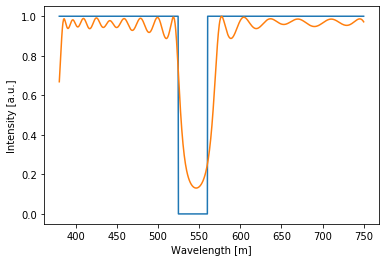

tensor(0.0186, dtype=torch.float64, grad_fn=<MseLossBackward>)
6


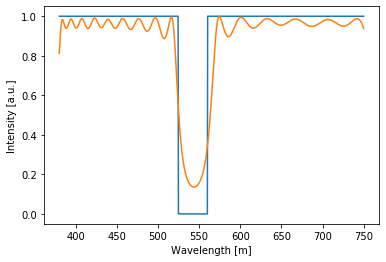

tensor(0.0133, dtype=torch.float64, grad_fn=<MseLossBackward>)
7


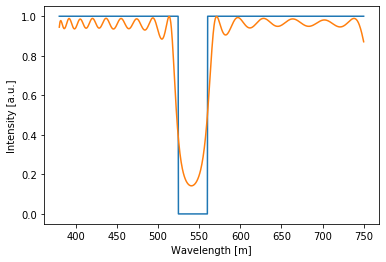

tensor(0.0125, dtype=torch.float64, grad_fn=<MseLossBackward>)
8


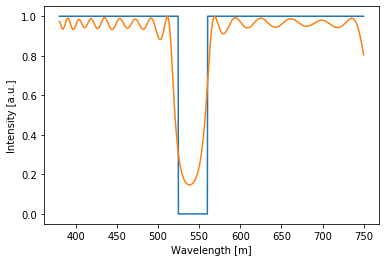

tensor(0.0156, dtype=torch.float64, grad_fn=<MseLossBackward>)
9


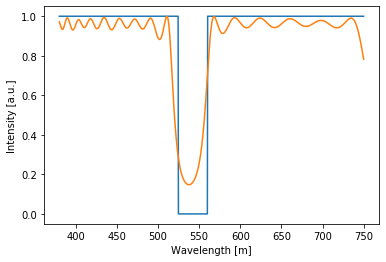

tensor(0.0172, dtype=torch.float64, grad_fn=<MseLossBackward>)
10


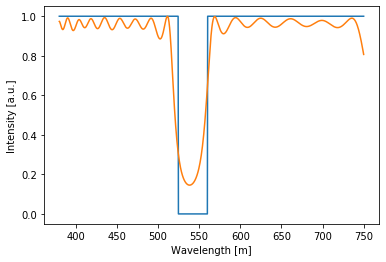

tensor(0.0155, dtype=torch.float64, grad_fn=<MseLossBackward>)
11


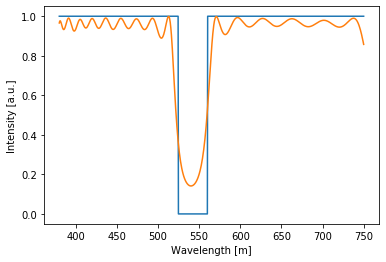

tensor(0.0130, dtype=torch.float64, grad_fn=<MseLossBackward>)
12


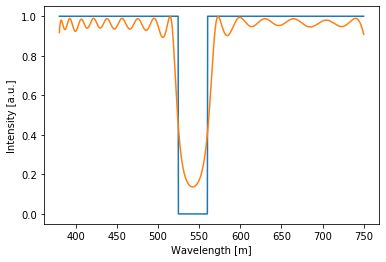

tensor(0.0123, dtype=torch.float64, grad_fn=<MseLossBackward>)
13


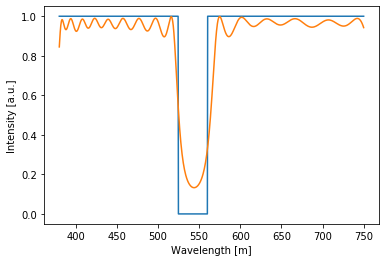

tensor(0.0135, dtype=torch.float64, grad_fn=<MseLossBackward>)
14


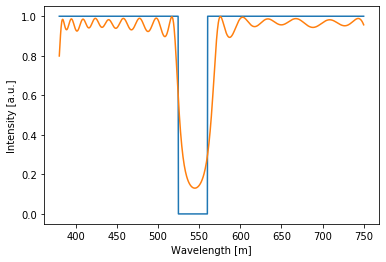

tensor(0.0148, dtype=torch.float64, grad_fn=<MseLossBackward>)
15


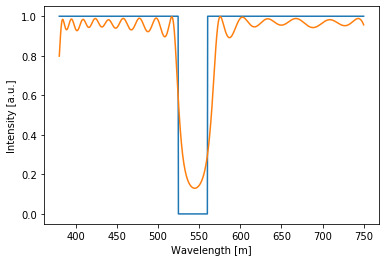

tensor(0.0146, dtype=torch.float64, grad_fn=<MseLossBackward>)
16


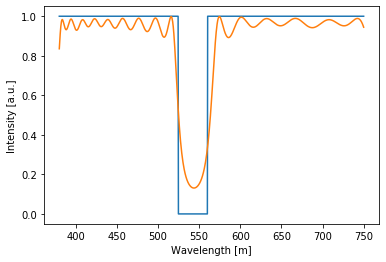

tensor(0.0133, dtype=torch.float64, grad_fn=<MseLossBackward>)
17


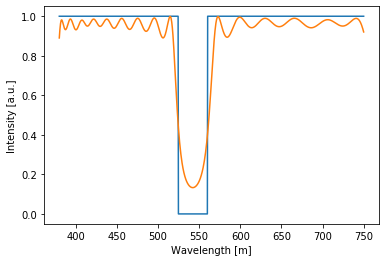

tensor(0.0122, dtype=torch.float64, grad_fn=<MseLossBackward>)
18


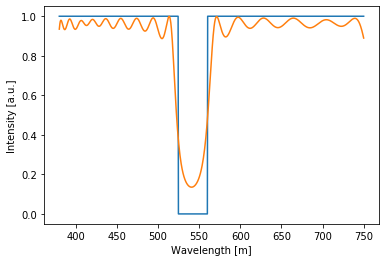

tensor(0.0124, dtype=torch.float64, grad_fn=<MseLossBackward>)
19


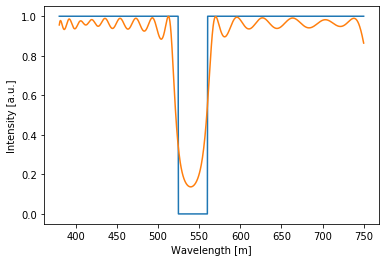

tensor(0.0133, dtype=torch.float64, grad_fn=<MseLossBackward>)
loss: 0.01326


In [49]:
from tqdm.notebook import tqdm

range_ = tqdm(range(20))
lossfunc = torch.nn.MSELoss()
with train_env: # temporarily override the global environment
    for i in range_:
        print(i)
        stack.initialize()
        optimizer.zero_grad() # set all the gradients to zero
       
        result = stack(source=1)[0,:,0,0].double() # single timestep, all wls, (drop detector=0; through detector=2), single batch
        loss = lossfunc(result, target_torch) # MSE loss
        loss.backward() # calculate the gradients
        optimizer.step() # use the calculated gradients to perform an optimization step
        range_.set_postfix(loss=loss.item())
        
        # Regularization : put a minimum bound on small layers
        for p in stack.parameters():
            if p < dB:
                p = dB
        
        stack.plot(target, label="target")
        stack.plot(result.detach().numpy())
        plt.show()
        
        print(loss)

print("loss: %.5f"%loss.item())

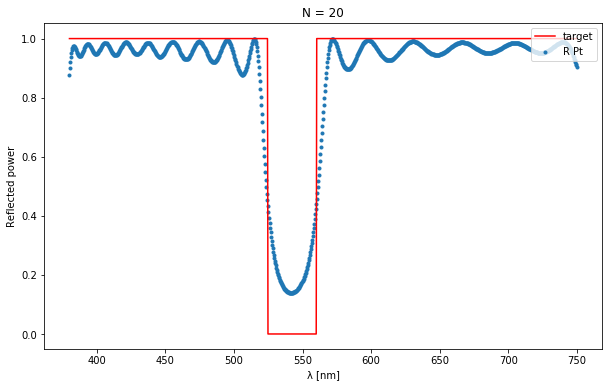

In [46]:
plt.figure(figsize=[10,6])
plt.scatter(wls, result.detach().numpy(), marker='.', label='R Pt')
#plt.plot(wls, Tnorm, 'k--', label='R tmm')
plt.plot(wls, target, 'r', label='target')
plt.xlabel("λ [nm]")
plt.ylabel("Reflected power")
plt.legend(loc="upper right")
plt.title("N = {}".format(N))
plt.show()

In [47]:
for p in stack.parameters():
    print(p)

Parameter containing:
tensor(91.6133, dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor(-39.4686, dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor(109.1604, dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor(37.8631, dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor(123.5507, dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor(33.0965, dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor(105.7495, dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor(-19.1223, dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor(99.3641, dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor(26.6255, dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor(117.9164, dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor(14.4113, dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor(121.1041, dtype=t